In [1]:
import pypsa
import pandas as pd
import numpy as np

In [2]:
solver = "cbc"

In [3]:
# To calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

#### Initialize network

*** 
Check-point 1:

**Build a network in PyPSA with three nodes (`bus`) and following components to build a simple green hydrogen production system:**

1. An `Electricity` bus with electricity as `carrier`.
   1. A wind generator inside this bus.
   2. A solar generator inside this bus.
2. A `Hydrogen` bus with hydrogen as `carrier`.
   1. A hydrogen demand load inside this bus.
3. An electrolyser link to convert electricity into hydrogen.
4. A `Hydrogen_storage` bus with hydrogen as `carrier`.
   1. A hydrogen store inside this bus.
5. A bidirectional link to transfar the hydrogen between hydrogen and hydrogen storage buses.

**For simplicity, we assume the hydrogen demand profile to be flat for now. Afterwards, we want to supply electricity by attaching two renewable power plants implemented as (`generator`) (you have to call [`network.set_snapshots`](https://pypsa.readthedocs.io/en/latest/api/_source/pypsa.Network.set_snapshots.html) to select a year). For help, you should have a look at the [PyPSA documentation](https://pypsa.readthedocs.io/en/latest/index.html#documentation) and the [optimzation with Linopy](https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy.html), understand what the [components documentation](https://pypsa.readthedocs.io/en/latest/user-guide/components.html) of PyPSA gives you and that you can find the underlying objective function and constraints in the [System Optimization documentation](https://pypsa.readthedocs.io/en/latest/user-guide/optimal-power-flow.html).**
> **Remarks:** For time reasons, you do not have to build the network from scratch. However, to get you acquainted with PyPSA we have omitted a few elements or some of the parameters of the network marked by three question marks `???`. Either, you have to add an element similar to the one in the box above or add a few parameters.

In [4]:
# Create empty PyPSA network
network = pypsa.Network()

In [5]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2023", "01-01-2024", freq="H", inclusive="left")
network.set_snapshots(snapshots)

In [6]:
network.snapshots

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq='H')

In [7]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv("../data/weather data/example_onshore_wind_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern)*365, index=network.snapshots)

In [8]:
# Import an example of solar daily pattern
solar_pattern = pd.read_csv("../data/weather data/example_solar_daily_pattern.csv")["daily pattern"]
# annual time-series availability of solar (just a simplified example)
solar_profile = pd.Series(list(solar_pattern)*365, index=network.snapshots)

Add an `electricity` bus with electricity as `carrier`

In [9]:
network.add(class_name="Bus", name="electricity", carrier="electricity")

Add a `hydrogen` bus with hydrogen as `carrier`

In [10]:
network.add(class_name="Bus", name="hydrogen", carrier="hydrogen")

Add a `hydrogen_storage` bus with hydrogen as `carrier`

In [11]:
network.add(class_name="Bus", name="hydrogen_storage", carrier="hydrogen")

In [12]:
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,1.0,,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,
hydrogen,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
hydrogen_storage,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,


Add a constant hourly hydrogen load of `100MW` at the hydrogen bus. The name of the load can be `hydrogen_load`

In [13]:
network.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=100)

In [14]:
network.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
hydrogen_load,hydrogen,,,100.0,0.0,-1.0


Add a store at the hydrogen_storage bus with a initial energy capacity of `0MWh`, and marginal cost of `0$/MWh` into the network? The name of the store can be `hydrogen_tank`. 

In [15]:
network.add(
      class_name="Store",
      name="hydrogen_tank",
      bus="hydrogen_storage",
      carrier="hydrogen",
      e_nom_extendable=True,
      e_cyclic=True,
      marginal_cost=0, #$/MWh
      )

Add a bidirectional link, representing the hydrogen charging and discharging between hydrogen and hydrogen_storage with marginal cost of `0$/MWh` into the network? The name of the link can be `hydrogen_flow`. 

In [16]:
network.add(
      class_name="Link",
      name="hydrogen_flow",
      bus0="hydrogen",
      bus1="hydrogen_storage",
      p_nom_extendable=True,
      marginal_cost=0, #$/MWh
      efficiency=1,
      p_min_pu=-1
      )

Add a wind generator at the electricity bus with a initial capacity of `100MW`, maximum capacity of `500MW`, based on provided CAPEX, FOM, VOM, efficiency, interest rate and lifetime? The name of the generator can be `onshore_wind`. 

> **Source:** all costs for the example are taken from PyPSA"s technology database (https://github.com/PyPSA/technology-data) and the assumptions in year 2023 in EU map of hydrogen production costs (https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [17]:
# Onshore Wind's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 25
interest = 0.05

CAPEX = 1420*eur_to_usd # $/MW
FOM = 28*eur_to_usd  # $/MW fixed
VOM = 0 # $/MWh variable

efficiency = 1

In [18]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Generator", 
    name="onshore_wind",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    p_nom=100, # MW
    p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=wind_profile
)

Add a solar generator at the electricity bus with a initial capacity of `10MW`, maximum capacity of `500MW`, based on provided CAPEX, FOM, VOM, efficiency, interest rate and lifetime? The name of the generator can be `solar`. 

> **Source:** all costs for the example are taken from PyPSA"s technology database (https://github.com/PyPSA/technology-data) and the assumptions in year 2023 in EU map of hydrogen production costs (https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [19]:
# Solar's techno-economic parameters are given as:
eur_to_use = 1.1
lifetime = 20
interest = 0.05

CAPEX = 970*eur_to_use # $/MW
FOM = 16*eur_to_use  # $/MW fixed
VOM = 0 # $/MWh variable

efficiency = 1

In [20]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Generator", 
    name="solar",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    p_nom=50,
    p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=solar_profile
)

In [21]:
network.generators

attribute,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
onshore_wind,electricity,PQ,,100.0,0.0,True,0.0,500.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solar,electricity,PQ,,50.0,0.0,True,0.0,500.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


Add an electrolyser link, representing the electrolysis conversion with initial capacity of `20MW`, based on provided CAPEX, FOM, VOM, efficiency, interest rate and lifetime.

> **Source:** all costs for the example are taken from PyPSA"s technology database (https://github.com/PyPSA/technology-data) and the assumptions in year 2023 in EU map of hydrogen production costs (https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [22]:
# Electrolyser's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 10
interest = 0.05

CAPEX = 1590*eur_to_usd # $/MW
FOM = 32*eur_to_usd  # $/MW fixed
VOM = 0 # $/MWh variable
efficiency = 0.65

In [23]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Link",
    name="electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom=20,
    capital_cost=annualized_capex + FOM, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime
)

Now try to solve your network

In [24]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name=solver)

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 58.88it/s]
INFO:linopy.io: Writing time: 1.12s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - cbc -printingOptions all -import /tmp/linopy-problem-n3b5r1l9.lp -pyomo False -solve -solu /tmp/linopy-solve-pg4f3bnc.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 30295 (-92352) rows, 21538 (-31028) columns and 77380 (-145642) elements
Perturbing problem by 0.001% of 400.04234 - largest nonzero change 0.0012900385 ( 0.00066481107%) - largest zero change 0.00050003945
0  Obj -23840.395 Primal inf 1420671 (8760)
376  Obj -23805.537 Primal inf 1421920.5 (8413)
752  Obj -23767.783 Primal inf 1483166.3 (8516)
1

('ok', 'optimal')

Lets look at some results! Back to read the docs. How would you look at results?

<Axes: xlabel='snapshot'>

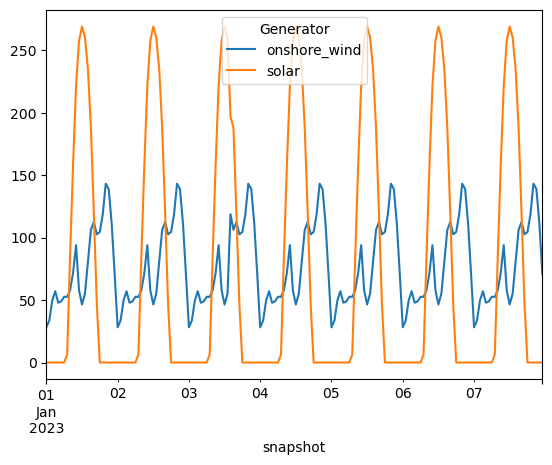

In [25]:
# Inspect the interaction of different power plants to supply loads
network.generators_t.p[:24*7].plot()

In [26]:
network.links_t.p0.head()

Link,hydrogen_flow,electrolyser
snapshot,,
2023-01-01 00:00:00,-81.678117,28.187513
2023-01-01 01:00:00,-78.105897,33.683236
2023-01-01 02:00:00,-67.641589,49.782172
2023-01-01 03:00:00,-62.882630,57.103646
2023-01-01 04:00:00,-68.881763,47.874211


In [27]:
network.links_t.p1.head()

Link,hydrogen_flow,electrolyser
snapshot,,
2023-01-01 00:00:00,81.678117,-18.321883
2023-01-01 01:00:00,78.105897,-21.894103
2023-01-01 02:00:00,67.641589,-32.358412
2023-01-01 03:00:00,62.882630,-37.117370
2023-01-01 04:00:00,68.881763,-31.118237


In [28]:
# Exporting check-point 1 network
network.export_to_netcdf("../results/network_d2_e4-1.nc")

INFO:pypsa.io:Exported network network_d2_e4-1.nc has stores, generators, loads, links, buses


<xarray.Dataset> Size: 1MB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   stores_i: 1, stores_t_p_i: 1,
                                   stores_t_e_i: 1, generators_i: 2,
                                   generators_t_p_max_pu_i: 2,
                                   generators_t_p_i: 2, loads_i: 1,
                                   loads_t_p_i: 1, links_i: 2, links_t_p0_i: 2,
                                   links_t_p1_i: 2, buses_i: 3, buses_t_p_i: 2,
                                   buses_t_marginal_price_i: 3)
Coordinates: (12/16)
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) int64 0B 
  * stores_i                      (stores_i) object 8B 'hydrogen_tank'
  * stores_t_p_i                  (stores_t_p_i) object 8B 'hydrogen_tank'
  * stores_t_e_i                  (stores_t_e_i) object 8B 'hydrogen_tank'
  * generators_i                  (generators_i) object 16B 'onshore_wind' 's...
    ...                            ...
  * links_i                       (links_i) object 16B 'hydrogen_flow' 'elect...
  * links_t_p0_i                  (links_t_p0_i) object 16B 'hydrogen_flow' '...
  * links_t_p1_i                  (links_t_p1_i) object 16B 'hydrogen_flow' '...
  * buses_i                       (buses_i) object 24B 'electricity' ... 'hyd...
  * buses_t_p_i                   (buses_t_p_i) object 16B 'electricity' 'hyd...
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 24B 'elec...
Data variables: (12/41)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) object 0B 
    investment_periods_years      (investment_periods) object 0B 
    ...                            ...
    links_p_nom_opt               (links_i) float64 16B 105.1 315.6
    links_t_p0                    (snapshots, links_t_p0_i) float64 140kB -81...
    links_t_p1                    (snapshots, links_t_p1_i) float64 140kB 81....
    buses_carrier                 (buses_i) object 24B 'electricity' ... 'hyd...
    buses_t_p                     (snapshots, buses_t_p_i) float64 140kB 0.0 ...
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 210kB ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           161992.21407957
    network_objective_constant:  24557.785889054718
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

***
Check-point 2:

**Remove the electrolyser link from the previous exercise and replace it with a new electrolyser link including compressor with cost assumption and efficiency adjustment**

In [29]:
# Import check-point 1 network
network = pypsa.Network("../results/network_d2_e4-1.nc")

INFO:pypsa.io:Imported network network_d2_e4-1.nc has buses, generators, links, loads, stores


In [30]:
# remove hydrogen load from previous check-point
network.remove(class_name="Load", name="hydrogen_load")

In [31]:
# remove electrolyser link from previous check-point
network.remove(class_name="Link", name="electrolyser")

Add a hourly hydrogen load at the hydrogen bus according to the daily pattern of industrial hydrogen demand (`100MW per hour` from 1am to 7pm, and with a shutodwn of 5 hours). The name of the load can be `hydroge_load`

**To set hourly hydrogen demand, you have to call [`network.set_snapshots`](https://pypsa.readthedocs.io/en/latest/api/_source/pypsa.Network.set_snapshots.html) to select a year.For help, you should have a look at the [PyPSA documentation](https://pypsa.readthedocs.io/en/latest/index.html#documentation) and the [optimzation with Linopy](https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy.html), understand what the [components documentation](https://pypsa.readthedocs.io/en/latest/user-guide/components.html) of PyPSA gives you and that you can find the underlying objective function and constraints in the [System Optimization documentation](https://pypsa.readthedocs.io/en/latest/user-guide/optimal-power-flow.html).**

In [32]:
# Import an example of wind daily pattern
load_pattern = pd.read_csv("../data/weather data/example_industrial_h2_demand_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
load_profile = pd.Series(list(load_pattern)*365, index=network.snapshots)

In [33]:
network.add(
    class_name="Load", 
    name="hydrogen_load", 
    bus="hydrogen", 
    p_set=load_profile
)

Add an electrolyser link including compressor, representing the electrolysis conversion with initial capacity of `20MW`, based on provided CAPEX, FOM, VOM, water_cost, efficiency, interest rate and lifetime.

> **Source:** all costs for the example are taken from PyPSA"s technology database (https://github.com/PyPSA/technology-data) and the assumptions in year 2023 in EU map of hydrogen production costs (https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [34]:
# Electrolyser's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 10
interest = 0.05
water_cost = 1.8 # EUR/m3, seawater
water_conversion_cost= 21 # kgH2O/kgH2

CAPEX = 1590*eur_to_usd # $/MW
FOM = 32*eur_to_usd  # $/MW fixed
VOM = 0 # $/MWh variable

# calculate marginal cost for water consumption (EUR/MWh)
# =water_cost*water_converstion_cost/(33.33(kWh)/1000)
water_cost = ((water_cost/1000)*water_conversion_cost)/(33.33/1000)*eur_to_usd # 1kgH2 = 33.33kWh

efficiency = 0.65


# Adding compressor to compress hydrogen from electrolyser into hydrogen storage
# 1. Convert electricity consumption for compressor from kWh_el/kg_h2 into kWh_el/kWh_h2
# 2. the new value represents the share of electricity consumption, and the rest of share will be used for electrolyzer.
electricity_consumption = 0.6  # kWh/kgH2
elect_share = 1 - (electricity_consumption/33.33)
new_efficiency = efficiency*elect_share

# Compressor's techno-economic parameters are given as:
lifetime_com = 25
CAPEX_COM = 1720*eur_to_usd # $/MW
FOM_COM = 34*eur_to_usd  # $/MW fixed
VOM_COM = 0 # $/MWh variable

In [35]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)
annualized_capex_com = calculate_annualised_capex(CAPEX_COM, interest, lifetime_com)

network.add(
    class_name="Link",
    name="electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom=20,
    capital_cost=annualized_capex + FOM + annualized_capex_com + FOM_COM, #$/MW
    marginal_cost=VOM + water_cost + VOM_COM, #$/MWh
    efficiency=new_efficiency,
    lifetime=lifetime
)

Ending of check-point 2 - Solve network, analyse results and export network

In [36]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name=solver)

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 47.93it/s]
INFO:linopy.io: Writing time: 0.95s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - cbc -printingOptions all -import /tmp/linopy-problem-pb_t6t25.lp -pyomo False -solve -solu /tmp/linopy-solve-januj_oq.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 28470 (-94177) rows, 19713 (-32853) columns and 73730 (-149292) elements
Perturbing problem by 0.001% of 400.95176 - largest nonzero change 0.00051217759 ( 0.26342346%) - largest zero change 0.00025046204
0  Obj -27693.235 Primal inf 1188834.8 (6935)
367  Obj -27641.028 Primal inf 1149185.2 (6568)
734  Obj -27002.974 Primal inf 1146786.5 (6201)
1

('ok', 'optimal')

<Axes: xlabel='snapshot'>

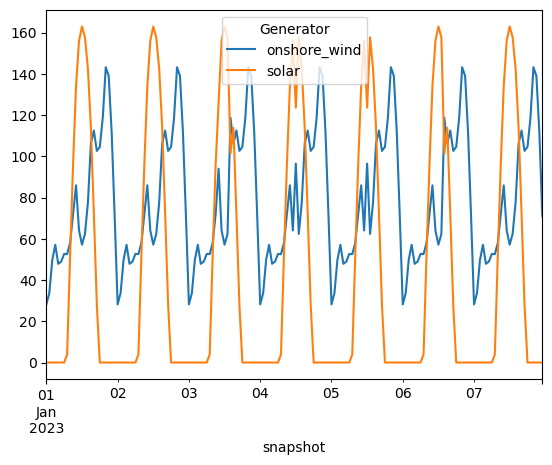

In [37]:
# Inspect the interaction of different power plants to supply loads
network.generators_t.p[:24*7].plot()

<Axes: xlabel='snapshot'>

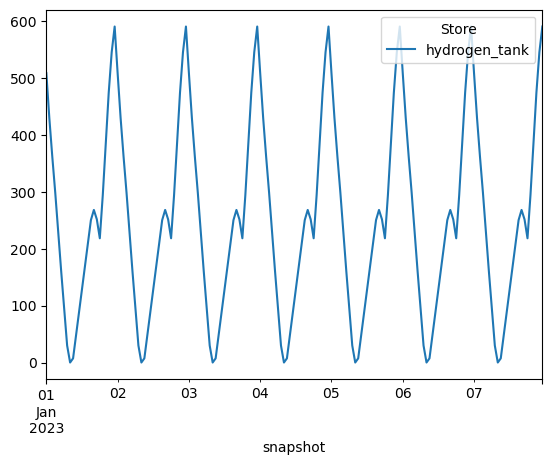

In [38]:
# Inspect the change of energy capacity in hydrogen_tank store to supply loads
network.stores_t.e[:24*7].plot()

<Axes: xlabel='snapshot'>

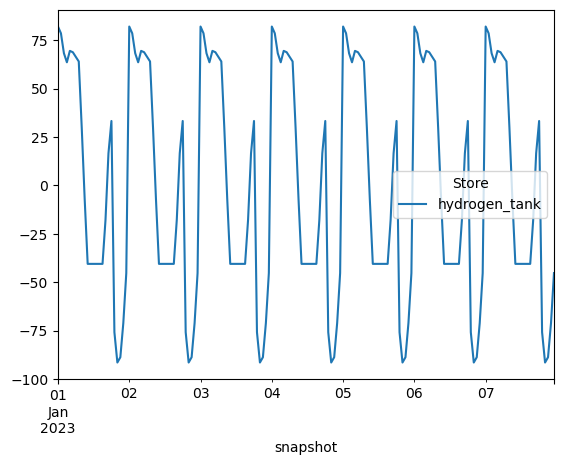

In [39]:
# Inspect the change of energy capacity in hydrogen_tank store to supply loads
network.stores_t.p[:24*7].plot()

<Axes: xlabel='snapshot'>

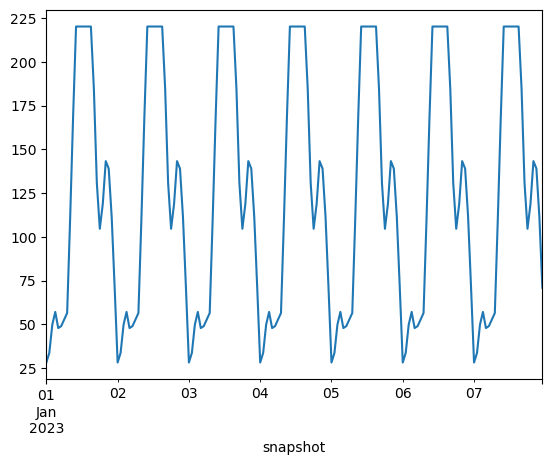

In [40]:
# Inspect the electrolysis conversion
network.links_t.p0["electrolyser"][:24*7].plot()

<Axes: xlabel='snapshot'>

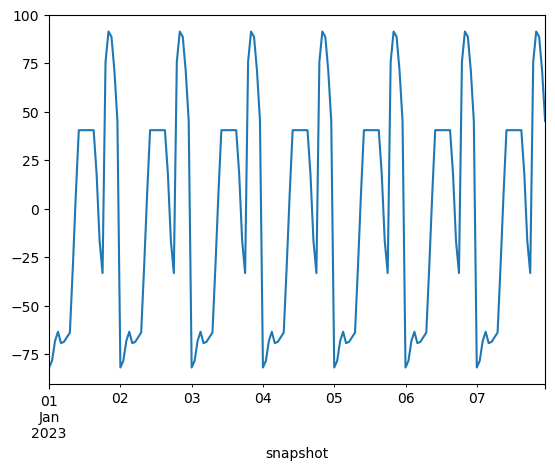

In [41]:
# Inspect the charging flow
network.links_t.p0["hydrogen_flow"][:24*7].plot()

In [42]:
# Exporting check-point 2 network
network.export_to_netcdf("../results/network_d2_e4-2.nc")

INFO:pypsa.io:Exported network network_d2_e4-2.nc has stores, generators, loads, links, buses


<xarray.Dataset> Size: 2MB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   stores_i: 1, stores_t_p_i: 1,
                                   stores_t_e_i: 1, generators_i: 2,
                                   generators_t_p_max_pu_i: 2,
                                   generators_t_p_i: 2, loads_i: 1,
                                   loads_t_p_set_i: 1, loads_t_p_i: 1,
                                   links_i: 2, links_t_p0_i: 2,
                                   links_t_p1_i: 2, buses_i: 3, buses_t_p_i: 2,
                                   buses_t_marginal_price_i: 3)
Coordinates: (12/17)
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) int64 0B 
  * stores_i                      (stores_i) object 8B 'hydrogen_tank'
  * stores_t_p_i                  (stores_t_p_i) object 8B 'hydrogen_tank'
  * stores_t_e_i                  (stores_t_e_i) object 8B 'hydrogen_tank'
  * generators_i                  (generators_i) object 16B 'onshore_wind' 's...
    ...                            ...
  * links_i                       (links_i) object 16B 'hydrogen_flow' 'elect...
  * links_t_p0_i                  (links_t_p0_i) object 16B 'hydrogen_flow' '...
  * links_t_p1_i                  (links_t_p1_i) object 16B 'hydrogen_flow' '...
  * buses_i                       (buses_i) object 24B 'electricity' ... 'hyd...
  * buses_t_p_i                   (buses_t_p_i) object 16B 'electricity' 'hyd...
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 24B 'elec...
Data variables: (12/42)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) float64 0B 
    investment_periods_years      (investment_periods) float64 0B 
    ...                            ...
    links_marginal_cost           (links_i) float64 16B 0.0 1.248
    links_t_p0                    (snapshots, links_t_p0_i) float64 140kB -82...
    links_t_p1                    (snapshots, links_t_p1_i) float64 140kB 82....
    buses_carrier                 (buses_i) object 24B 'electricity' ... 'hyd...
    buses_t_p                     (snapshots, buses_t_p_i) float64 140kB 0.0 ...
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 210kB ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           1513701.74354438
    network_objective_constant:  27990.626873257563
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}